In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline


In [3]:
train = pd.read_csv('../input/train_2.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [5]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [6]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

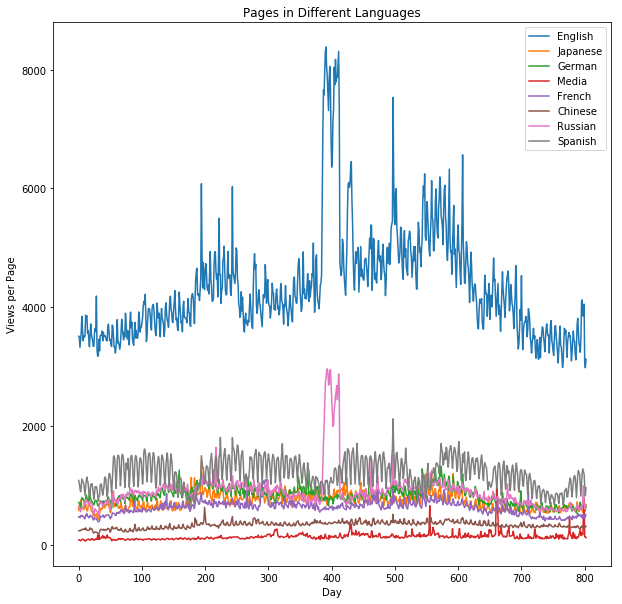

In [7]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

In [8]:
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page         total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  1.719626e+10
9774       Main_Page_en.wikipedia.org_desktop_all-agents  1.292035e+10
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents  3.838849e+09
39180  Special:Search_en.wikipedia.org_all-access_all...  1.900465e+09
10403  Special:Search_en.wikipedia.org_desktop_all-ag...  1.403199e+09
74690  Special:Search_en.wikipedia.org_mobile-web_all...  4.971283e+08
39172  Special:Book_en.wikipedia.org_all-access_all-a...  2.170866e+08
10399   Special:Book_en.wikipedia.org_desktop_all-agents  2.161755e+08
33644       Main_Page_en.wikipedia.org_all-access_spider  1.878491e+08
34257  Special:Search_en.wikipedia.org_all-access_spider  1.824502e+08



ja
                                                     Page        total
120336      メインページ_ja.wikipedia.org_all-access_all-agents  322682669.0
86431          メインページ_ja.wikipedia.org_desktop_all-agents  199278804

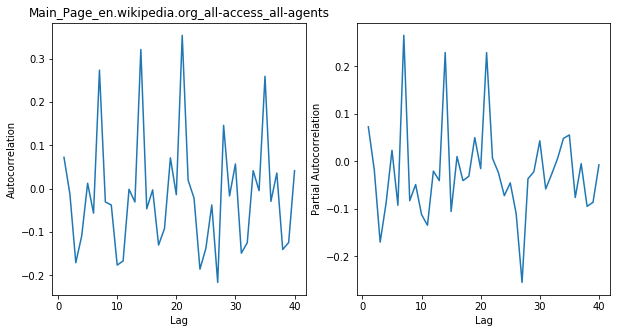

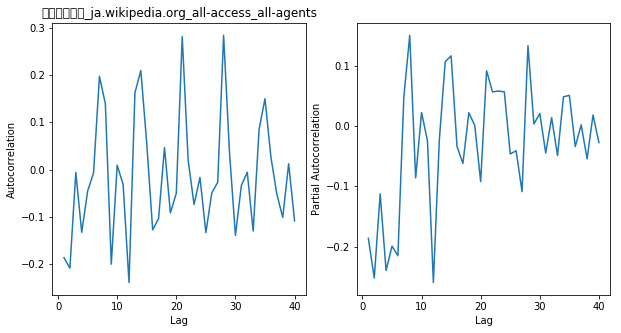

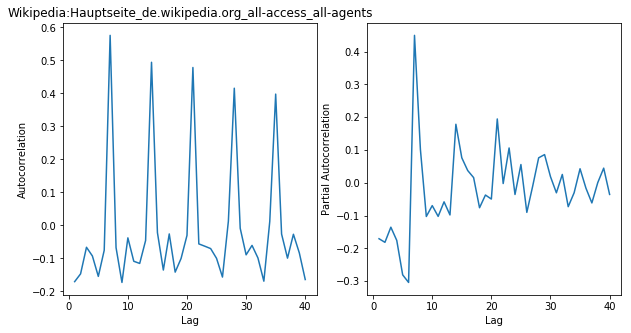

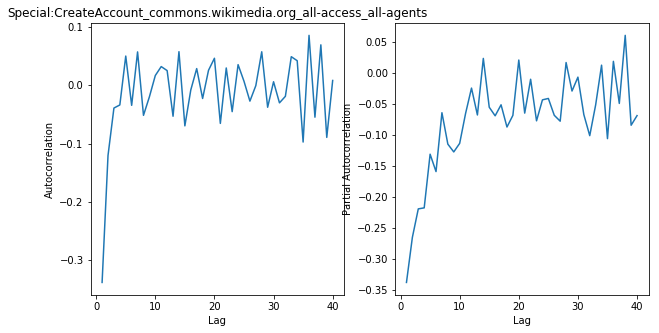

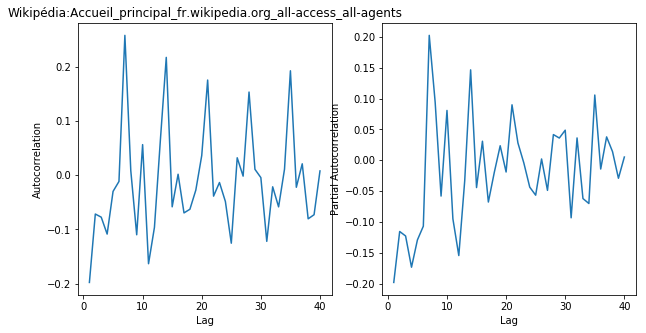

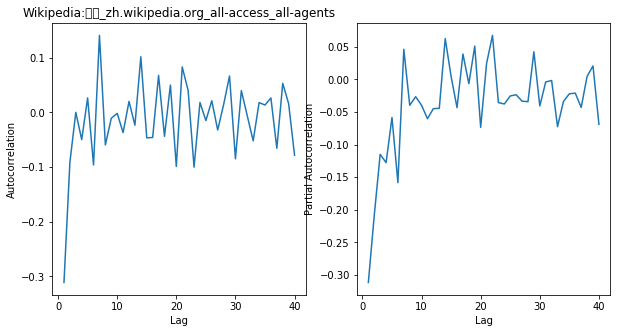

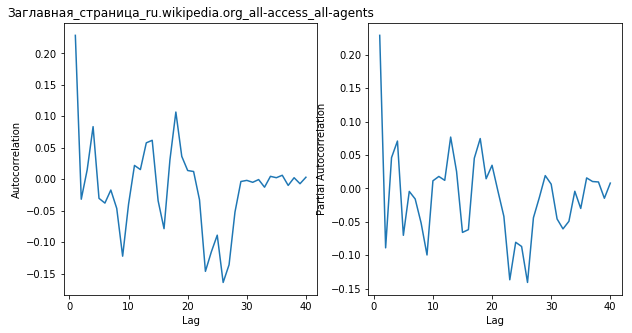

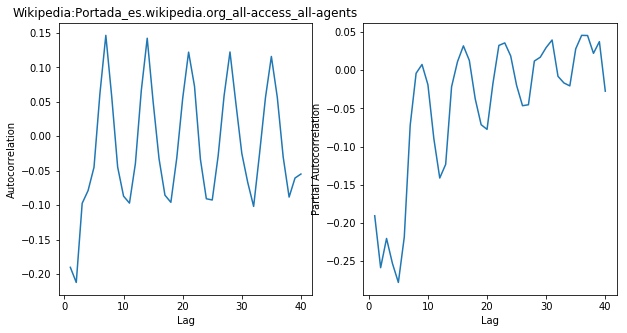

In [10]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

for key in top_pages:
    fig = plt.figure(1,figsize=[10,5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    cols = train.columns[1:-1]
    data = np.array(train.loc[top_pages[key],cols])
    data_diff = [data[i] - data[i-1] for i in range(1,len(data))]
    autocorr = acf(data_diff)
    pac = pacf(data_diff)

    x = [x for x in range(len(pac))]
    ax1.plot(x[1:],autocorr[1:])

    ax2.plot(x[1:],pac[1:])
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Autocorrelation')
    ax1.set_title(train.loc[top_pages[key],'Page'])

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Partial Autocorrelation')
    plt.show()

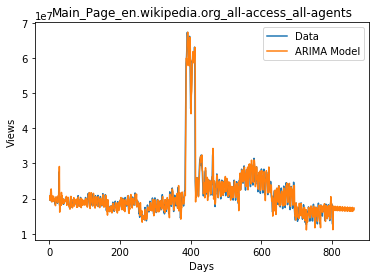

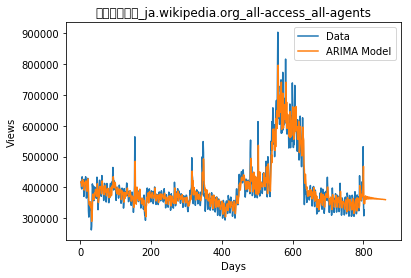

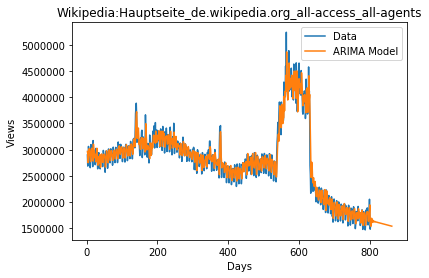

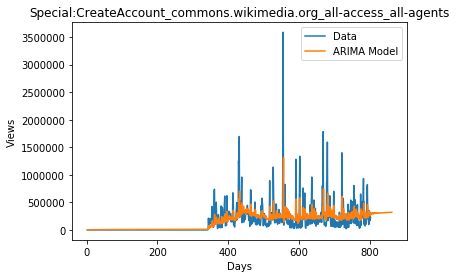

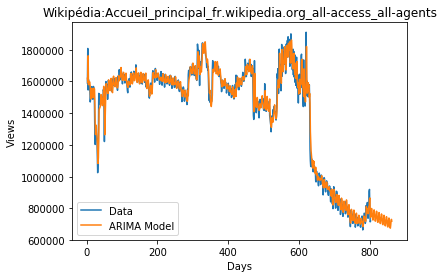

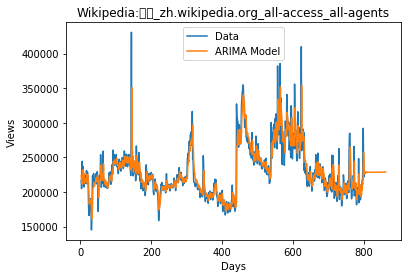

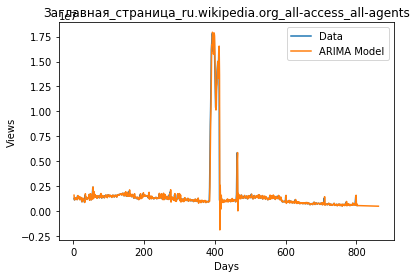

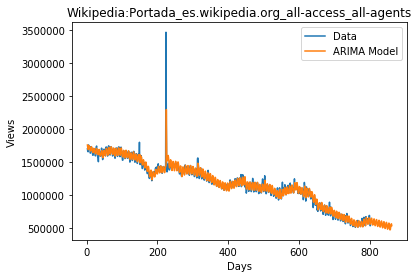

In [13]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

cols = train.columns[1:-1]
for key in top_pages:
    data = np.array(train.loc[top_pages[key],cols],'f')
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(data,[2,1,4])
            result = arima.fit(disp=False)
        except:
            try:
                arima = ARIMA(data,[2,1,2])
                result = arima.fit(disp=False)
            except:
                print(train.loc[top_pages[key],'Page'])
                print('\tARIMA failed')
    #print(result.params)
    pred = result.predict(2,862,typ='levels')
    x = [i for i in range(863)]
    i=0

    plt.plot(x[2:len(data)],data[2:] ,label='Data')
    plt.plot(x[2:],pred,label='ARIMA Model')
    plt.title(train.loc[top_pages[key],'Page'])
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.legend()
    plt.show()